In [1]:
import pandas as pd
# import pandasql as ps
import matplotlib.pyplot as plt
# Import argsort
from numpy import argsort
from Functions.connection.connection import *
from Functions.AlertP1.data_cleaning import *
from Functions.AlertP1.features import *
from Functions.analysis.step_analysis import *
from Functions.AlertP1.dummy_features import *
from Functions.Models.xgboost import *
from Functions.Models.evaluation import *
from Functions.NLP.alertp1_nlp import *
from Functions.NLP.data_with_nlp import *
from Functions.Pipelines.pipeline_non_NLP import *

In [2]:
alertP1=connection("credentials.txt")

Tables: [('ConsultaUrgencia_doentespedidosconsultaNeurologia2012',), ('consultaneurologia2012',), ('consultaneurologia201216anon_true',), ('hgo_data_032023',)]
671


/Users/miguelcosta/Desktop/PBL/PBL-HGO-1/Functions/connection/connection.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  alertP1 = pd.read_sql("""SELECT * FROM consultaneurologia201216anon_true""",mydb)


In [3]:
data = pre_process(alertP1)

/Users/miguelcosta/Desktop/PBL/PBL-HGO-1/Functions/AlertP1/data_cleaning.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alertP1['PROVENIENCIA'][alertP1['PROVENIENCIA']=='']='unknown'
/Users/miguelcosta/Desktop/PBL/PBL-HGO-1/Functions/AlertP1/data_cleaning.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alertP1['CTH_PRIOR'][alertP1['CTH_PRIOR']=='']='unknown'
/Users/miguelcosta/Desktop/PBL/PBL-HGO-1/Functions/AlertP1/data_cleaning.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

In [10]:
def xgb_classifier(features, target):
    # split X and y into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2,random_state=16,shuffle=False)

    #X_train['before_accepted'] = X_train['before_accepted'].astype('category')
    #X_test['before_accepted'] = X_test['before_accepted'].astype('category')

    # Convert data into DMatrix format
    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical = True)
    dtest = xgb.DMatrix(X_test, enable_categorical = True)

    # Set parameters for the XGBoost model
    param = {
        'max_depth': 3,
        'eta': 0.3,
        'objective': 'binary:logistic',
        'seed': 16
    }

    # Train the model
    num_round = 10
    bst = xgb.train(param, dtrain, num_round)

    # Make preictions on the train set
    y_pred_train = bst.predict(dtrain)
    # Make predictions on the test set
    y_pred_test = bst.predict(dtest)
    
    return y_pred_train, y_pred_test, bst.get_score(), X_train, X_test, y_train, y_test  

In [7]:
data.columns

Index(['ID_DOENTE', 'PROCESSO', 'COD_REFERENCIA', 'COD_PZ',
       'COD_UNID_SAUDE_PROV', 'UNID_PROV', 'TIPO_UNID', 'COD_CTH_PRIOR',
       'CTH_PRIOR', 'COD_MOTIVO_RECUSA', 'DES_MOTIVO_RECUSA',
       'COD_ESPECIALIDADE', 'DES_ESPECIALIDADE', 'agrupadora',
       'OUTRA_ENTIDADE', 'DATA_RECEPCAO', 'DATA_ENVIO', 'DATA_RETORNO',
       'NUM_TAXA', 'ESTADO', 'DATA_MARCACAO', 'DATA_REALIZACAO', 'OBSERVACOES',
       'Mês_entrada', 'Ano_entrada', 'trata data recusa', 'resume saída',
       'mês_saida', 'ano_saida', 'Texto', 'result', 'text_length',
       'outside area', 'SAM', 'SON', 'unknown', 'Other specialities', '2',
       '3+', 'HOSP', 'UCSP', 'USF A', 'USF B', 'outro', 'not accepted before'],
      dtype='object')

In [12]:
eliminate_cols=['ID_DOENTE','PROCESSO','COD_REFERENCIA','result','COD_PZ','COD_UNID_SAUDE_PROV','UNID_PROV','TIPO_UNID','COD_CTH_PRIOR','CTH_PRIOR','COD_MOTIVO_RECUSA','DES_MOTIVO_RECUSA','COD_ESPECIALIDADE','DES_ESPECIALIDADE','agrupadora','OUTRA_ENTIDADE','DATA_RECEPCAO','DATA_ENVIO','DATA_RETORNO','NUM_TAXA','ESTADO','DATA_MARCACAO','DATA_REALIZACAO','OBSERVACOES','Mês_entrada','Ano_entrada','trata data recusa','resume saída','mês_saida','ano_saida','Texto']
X = data.drop(eliminate_cols,axis=1)# Features
y = data.result # Target variable
features=X.columns



In [13]:
y_pred_train, y_pred_test, model_score, X_train, X_test, y_train, y_test = xgb_classifier(X,y)

In [82]:
thresholds = np.linspace(0, 1, 100)
kappas = [cohen_kappa_score(y_train, (y_pred_train >= t).astype(int)) for t in thresholds]
kappa_threshold = thresholds[np.argmax(kappas)]
kappa_y_pred_binary = (y_pred_test >= kappa_threshold).astype(int)



In [73]:
from fairlearn.metrics import MetricFrame, selection_rate
from fairlearn.reductions import GridSearch, ExponentiatedGradient
from sklearn.metrics import accuracy_score

In [80]:
sam = X_test['SAM']

In [83]:
gm = MetricFrame(metrics=accuracy_score, y_true=y_test, y_pred=kappa_y_pred_binary, sensitive_features=sam)
print(gm.overall)
print(gm.by_group)

0.6869333333333333
SAM
False    0.768569
True     0.511745
Name: accuracy_score, dtype: float64


array([[<Axes: title={'center': 'accuracy'}, xlabel='SAM'>,
        <Axes: title={'center': 'precision'}, xlabel='SAM'>,
        <Axes: title={'center': 'selection rate'}, xlabel='SAM'>],
       [<Axes: xlabel='SAM'>, <Axes: xlabel='SAM'>, <Axes: xlabel='SAM'>],
       [<Axes: xlabel='SAM'>, <Axes: xlabel='SAM'>, <Axes: xlabel='SAM'>]],
      dtype=object)

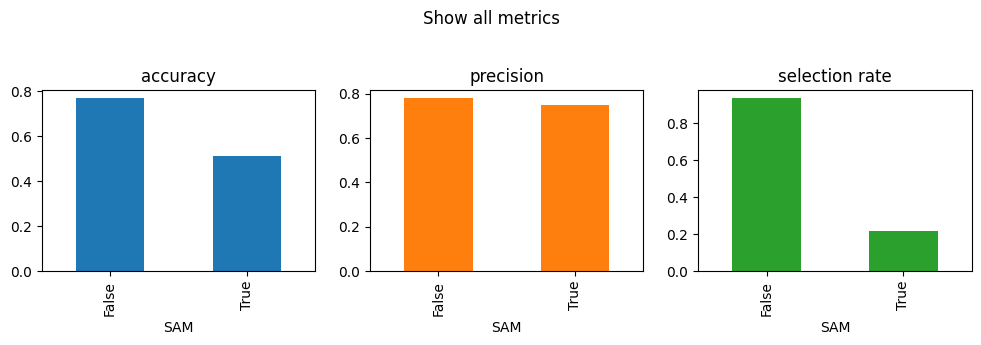

In [84]:
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "selection rate": selection_rate,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=kappa_y_pred_binary, sensitive_features=sam
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

In [ ]:
from fairlearn.metrics import MetricFrame, selection_rate
import matplotlib.pyplot as plt


# Create a MetricFrame object for the 'sam' sensitive feature
mf_sam = MetricFrame(metrics=selection_rate, y_true=y_test, y_pred=kappa_y_pred_binary, sensitive_features=X_test['SAM'])

# Create a MetricFrame object for the 'son' sensitive feature
mf_son = MetricFrame(metrics=selection_rate, y_true=y_test, y_pred=kappa_y_pred_binary, sensitive_features=X_test['SON'])

# Plot the selection rates for each group within the 'sam' and 'son' sensitive features
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
mf_sam.by_group.plot.bar(ax=axs[0], title='Selection Rates by SAM')
mf_son.by_group.plot.bar(ax=axs[1], title='Selection Rates by SON')
plt.show()


In [85]:
X_test.columns

Index(['text_length', 'outside area', 'SAM', 'SON', 'unknown',
       'Other specialities', '2', '3+', 'HOSP', 'UCSP', 'USF A', 'USF B',
       'outro', 'not accepted before'],
      dtype='object')

In [105]:
from fairlearn.metrics import MetricFrame, selection_rate
import matplotlib.pyplot as plt
import math

def plot_selection_rates(X_test, y_test, y_pred, ncols=3, hspace=0.5):
    
    cols = ['outside area', 'SAM', 'SON', 'unknown', 'Other specialities', '2', '3+', 'HOSP', 'UCSP', 'USF A', 'USF B', 'outro', 'not accepted before']

    # Get the number of columns to plot
    n_cols = len(cols)
    
    # Calculate the number of rows needed to arrange the subplots in a grid with ncols columns
    nrows = math.ceil(n_cols / ncols)
    
    # Create a figure with nrows rows and ncols columns of subplots
    fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows))
    
    # Flatten the axs array to make it easier to index
    axs = axs.flatten()
    
    # Loop over the specified columns
    for i, col in enumerate(cols):
        # Create a MetricFrame object for the current column
        mf = MetricFrame(metrics=selection_rate, y_true=y_test, y_pred=y_pred, sensitive_features=X_test[col])
        
        # Plot the selection rates for each group within the current column
        mf.by_group.plot.bar(ax=axs[i], title=f'Selection Rates by {col}')
    
    # Add space between the rows of subplots
    plt.subplots_adjust(hspace=hspace)
    plt.show()


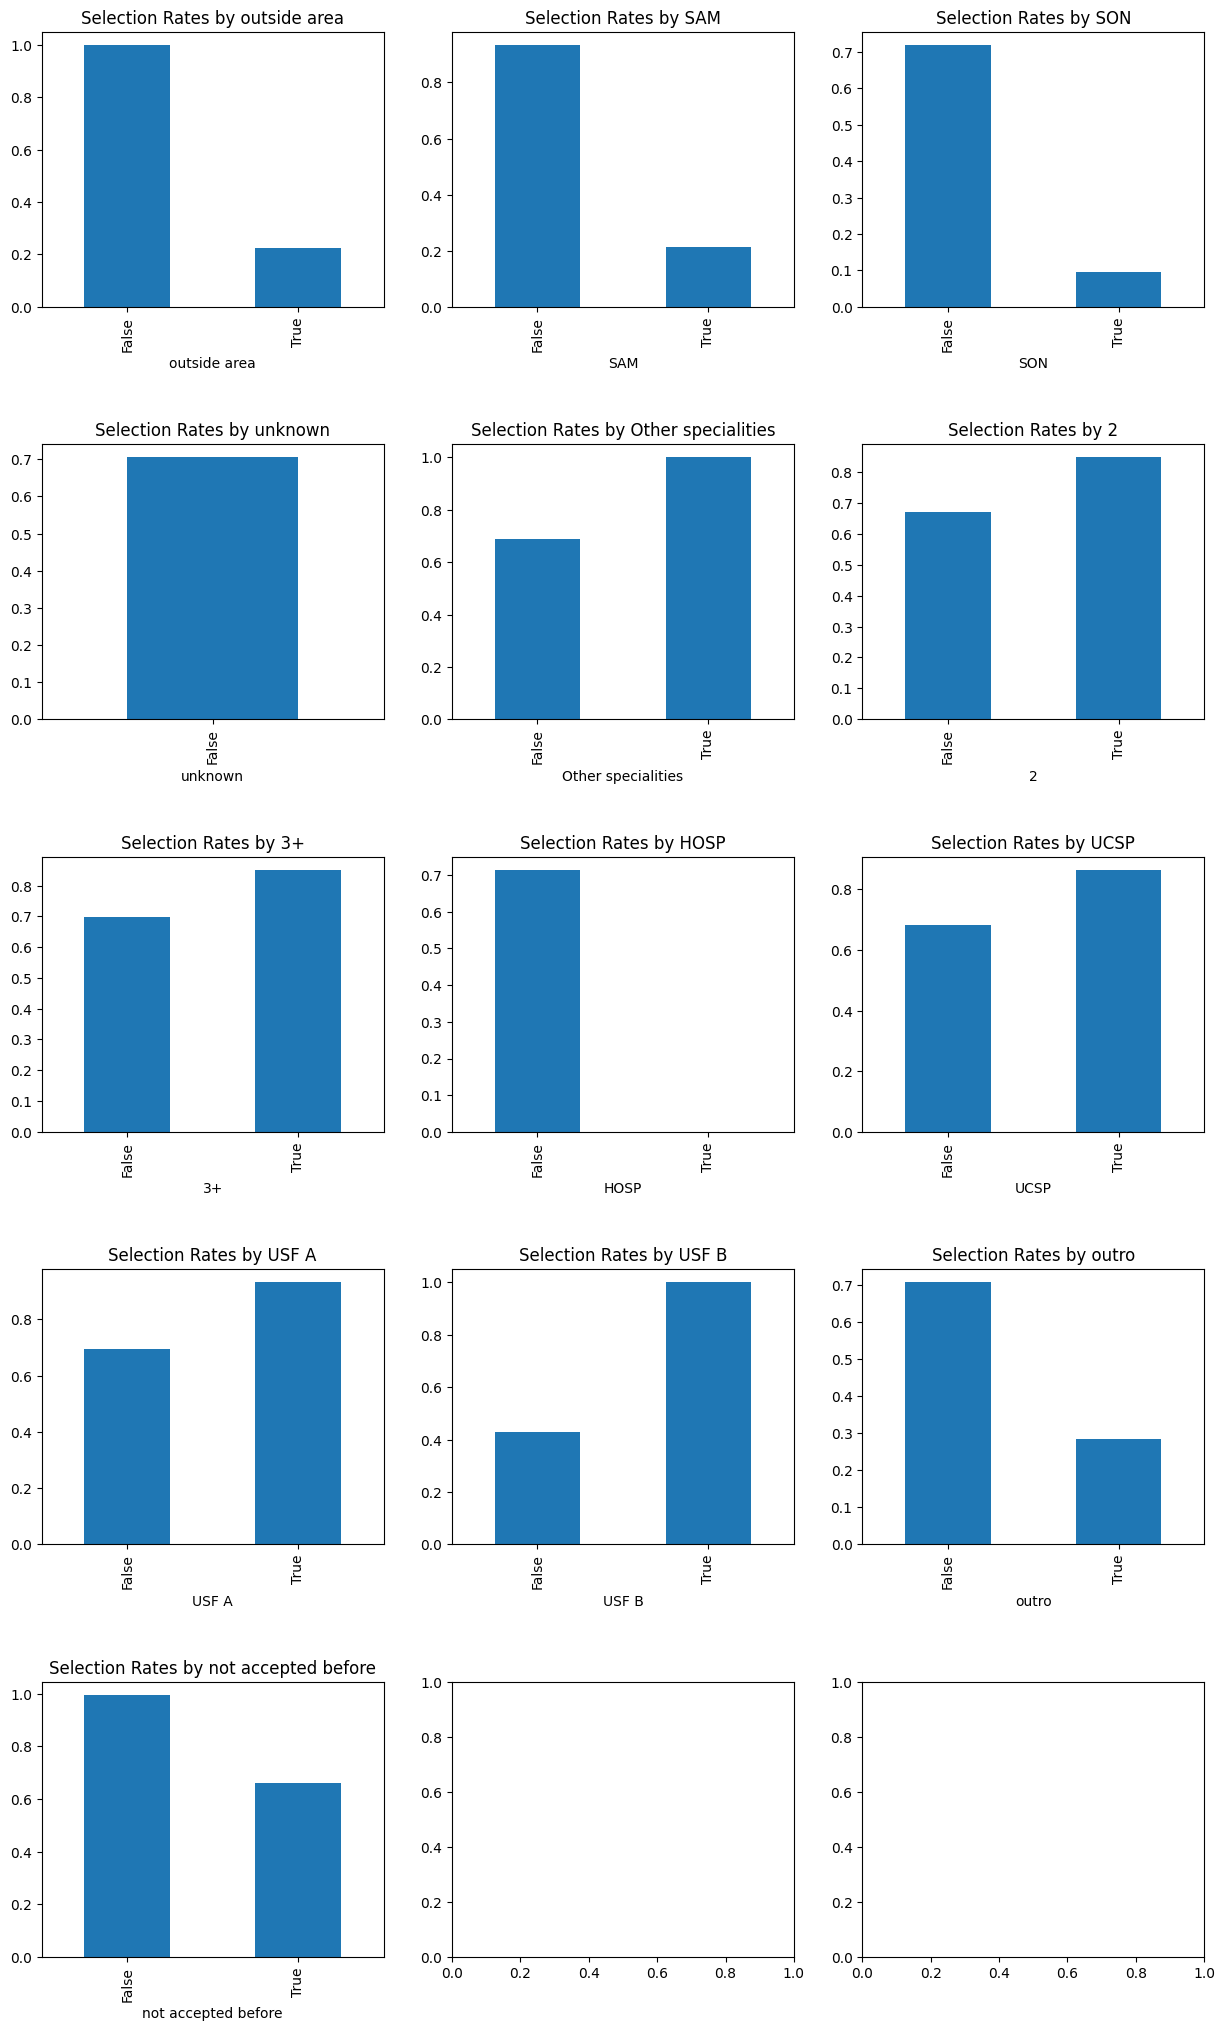

In [106]:
plot_selection_rates(X_test, y_test, kappa_y_pred_binary, ncols=3, hspace=0.5)